**------------------------------------------------------------------------------------------------------------------------------------------------------**

**Input: Annotated Dataset**

**Computes the Kappa-Score + T-test/Wilcoxon**

**Output: Kappa-Score + T-test/Wilcoxon**

**------------------------------------------------------------------------------------------------------------------------------------------------------**

# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import cohen_kappa_score
import statistics
from scipy import stats
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")

**Get Annotated Datasets**

Get Alie's annotations.

In [2]:
df_alie = pd.read_excel('../Input Data/Dataset_2_annotate_Alie.xlsx', sheet_name='Dataset_2_annotate')
df_alie.head()

,Food label,Subs A,Subs B,Relevance,Healthiness,Explanation E,Questions
0,"BUTTER OIL,ANHYDROUS","CHEESE,MEXICAN,QUESO CHIHUAHUA","CHEESE,LOW-SODIUM,CHEDDAR OR COLBY",No,Sub B,NaN,NaN
1,"CHEESE,BRICK","CHEESE,LOW-SODIUM,CHEDDAR OR COLBY","CHEESE,MOZZARELLA,WHL MILK",NaN,Sub A,NaN,NaN
2,"CHEESE,CHEDDAR","CHEESE,COLBY","EGG,WHL,RAW,FRSH",Sub A,Sub B,NaN,NaN
3,"CHEESE,FETA","CHEESE,FONTINA","CHEESE,SWISS",NaN,Sub B,"Swiss: similar energy, higher protein, lower s...",NaN
4,"CHEESE,FONTINA","CHEESE,BRIE","CHEESE,SWISS",NaN,Sub B,"Swiss: higher energy, more protein, less sodiu...",NaN


Get Ilse's annotations.

In [3]:
df_ilse = pd.read_excel('../Input Data/Dataset_2_annotate_Ilse.xlsx', sheet_name='Dataset_2_annotate')
df_ilse.head()

,Food label,Subs A,Subs B,Relevance,Healthiness,Explanation E
0,"BUTTER OIL,ANHYDROUS","CHEESE,MEXICAN,QUESO CHIHUAHUA","CHEESE,LOW-SODIUM,CHEDDAR OR COLBY",No,Sub B,NaN
1,"CHEESE,BRICK","CHEESE,LOW-SODIUM,CHEDDAR OR COLBY","CHEESE,MOZZARELLA,WHL MILK",NaN,Sub A,NaN
2,"CHEESE,CHEDDAR","CHEESE,COLBY","EGG,WHL,RAW,FRSH",Sub A,Sub B,NaN
3,"CHEESE,FETA","CHEESE,FONTINA","CHEESE,SWISS",NaN,Sub B,NaN
4,"CHEESE,FONTINA","CHEESE,BRIE","CHEESE,SWISS",NaN,Sub B,NaN


**Merge all datasets into one**

In [4]:
df = pd.DataFrame()
df['Food label'] = df_alie['Food label']
df['Subs A'] = df_alie['Subs A']
df['Subs B'] = df_alie['Subs B']
df['Healthiness_Alie'] = df_alie['Healthiness']
df['Healthiness_Ilse'] = df_ilse['Healthiness']
df.head()

,Food label,Subs A,Subs B,Healthiness_Alie,Healthiness_Ilse
0,"BUTTER OIL,ANHYDROUS","CHEESE,MEXICAN,QUESO CHIHUAHUA","CHEESE,LOW-SODIUM,CHEDDAR OR COLBY",Sub B,Sub B
1,"CHEESE,BRICK","CHEESE,LOW-SODIUM,CHEDDAR OR COLBY","CHEESE,MOZZARELLA,WHL MILK",Sub A,Sub A
2,"CHEESE,CHEDDAR","CHEESE,COLBY","EGG,WHL,RAW,FRSH",Sub B,Sub B
3,"CHEESE,FETA","CHEESE,FONTINA","CHEESE,SWISS",Sub B,Sub B
4,"CHEESE,FONTINA","CHEESE,BRIE","CHEESE,SWISS",Sub B,Sub B


**Preprocess the dataframe**

In [5]:
print(Counter(df['Healthiness_Alie']))
print(Counter(df['Healthiness_Ilse']))

Counter({nan: 721, 'NC': 222, 'Sub B': 124, 'Sub A': 120})
Counter({nan: 655, 'NC': 234, 'Sub A': 150, 'Sub B': 148})


If any NA values are present, then drop that row.

In [6]:
df_filtered = df.dropna(subset=['Healthiness_Alie', 'Healthiness_Ilse'], how='any')

In [7]:
print(Counter(df_filtered['Healthiness_Alie']))
print(Counter(df_filtered['Healthiness_Ilse']))

Counter({'NC': 222, 'Sub B': 123, 'Sub A': 120})
Counter({'NC': 217, 'Sub B': 125, 'Sub A': 123})


**Compute Kappa-Score**

In [8]:
cohen_kappa_score(df_filtered['Healthiness_Alie'], df_filtered['Healthiness_Ilse'])

0.7066692769511878

In [9]:
match = df_filtered[df_filtered['Healthiness_Alie'] == df_filtered['Healthiness_Ilse']]
num_match = len(match)
print(f'# Matches between Nutri-Scholars: {num_match}')

# Matches between Nutri-Scholars: 378


In [10]:
print(f'# Dataset (after removing NA): {len(df_filtered)}')

# Dataset (after removing NA): 465


In [11]:
num_match/len(df_filtered)

0.8129032258064516

This cell purely computes the 3x3 contingency matrix as shown in the paper (see Table 7.3).

In [12]:
cell_a = 0
cell_b = 0
cell_c = 0
cell_d = 0
cell_e = 0
cell_f = 0
cell_g = 0
cell_h = 0
cell_i = 0

for i, row in df_filtered.iterrows():
    if row['Healthiness_Alie'] == 'Sub A' and row['Healthiness_Ilse'] == 'Sub A':
        cell_a += 1 
    elif row['Healthiness_Alie'] == 'Sub B' and row['Healthiness_Ilse'] == 'Sub A':
        cell_b += 1 
    elif row['Healthiness_Alie'] == 'NC' and row['Healthiness_Ilse'] == 'Sub A':
        cell_c += 1 
    elif row['Healthiness_Alie'] == 'Sub A' and row['Healthiness_Ilse'] == 'Sub B':
        cell_d += 1 
    elif row['Healthiness_Alie'] == 'Sub B' and row['Healthiness_Ilse'] == 'Sub B':
        cell_e += 1 
    elif row['Healthiness_Alie'] == 'NC' and row['Healthiness_Ilse'] == 'Sub B':
        cell_f += 1 
    elif row['Healthiness_Alie'] == 'Sub A' and row['Healthiness_Ilse'] == 'NC':
        cell_g += 1 
    elif row['Healthiness_Alie'] == 'Sub B' and row['Healthiness_Ilse'] == 'NC':
        cell_h += 1 
    elif row['Healthiness_Alie'] == 'NC' and row['Healthiness_Ilse'] == 'NC':
        cell_i += 1 

**T-Test**

Sample 2 or Y: nutri-score values that are obtained by looking at the annotations for which both experts agreed (e.g., what is healthiest from a nutritional point of view).

Sample 1 or X: nutri-score values that are attained by looking at the oppositie of what the experts chose (e.g., what is not healthiest from a nutrtitional point of view).

Goal: test whether the mean of sample 1 is significantly different from the mean of sample 2

In [13]:
nutri_scores = pd.read_csv('../Output/nutri_scores.csv')
nutri_scores = nutri_scores[['Shrt_Desc', 'nutri_values']]

In [14]:
match = match.merge(df)
match = match.merge(nutri_scores, left_on='Subs A', right_on='Shrt_Desc')
match = match[['Food label', 'Subs A', 'Subs B', 'Healthiness_Alie', 'nutri_values']]
match.rename(columns = {'nutri_values':'Nutri-Values Sub A'}, inplace = True)
match = match.merge(nutri_scores, left_on='Subs B', right_on='Shrt_Desc')
match = match[['Food label', 'Subs A', 'Subs B', 'Healthiness_Alie', 'Nutri-Values Sub A', 'nutri_values']]
match.rename(columns = {'nutri_values':'Nutri-Values Sub B'}, inplace = True)
match.head()

,Food label,Subs A,Subs B,Healthiness_Alie,Nutri-Values Sub A,Nutri-Values Sub B
0,"BUTTER OIL,ANHYDROUS","CHEESE,MEXICAN,QUESO CHIHUAHUA","CHEESE,LOW-SODIUM,CHEDDAR OR COLBY",Sub B,16,9
1,"CHEESE,MOZZARELLA,LO MOIST,PART-SKIM","CHEESE,MOZZARELLA,WHL MILK","CHEESE,LOW-SODIUM,CHEDDAR OR COLBY",Sub B,14,9
2,"CHEESE,BRICK","CHEESE,LOW-SODIUM,CHEDDAR OR COLBY","CHEESE,MOZZARELLA,WHL MILK",Sub A,9,14
3,"CHEESE,MONTEREY","CHEESE,LOW-SODIUM,CHEDDAR OR COLBY","CHEESE,MOZZARELLA,WHL MILK",Sub A,9,14
4,"CHEESE,LIMBURGER","CHEESE,LOW-SODIUM,CHEDDAR OR COLBY","CHEESE,MEXICAN,QUESO ASADERO",Sub A,9,16


Here, we create sample 1 (called X) and sample 2 (called Y).

Sample 2: Nutri value scores of the substitutes for which both experts agreed. 

Sample 1: Nutri value scores of the opposite substitutes for which both experts agreed.

In [15]:
X = [] 
Y = []

for i, row in match.iterrows():
    if row['Healthiness_Alie'] == 'Sub A':
        Y.append(row['Nutri-Values Sub A'])
        X.append(row['Nutri-Values Sub B'])
    elif row['Healthiness_Alie'] == 'Sub B':
        Y.append(row['Nutri-Values Sub B'])
        X.append(row['Nutri-Values Sub A'])
    else: 
        X.append(np.nan)
        Y.append(np.nan)
        
match['X'] = X
match['Y'] = Y
match = match.dropna()
match.head()

,Food label,Subs A,Subs B,Healthiness_Alie,Nutri-Values Sub A,Nutri-Values Sub B,X,Y
0,"BUTTER OIL,ANHYDROUS","CHEESE,MEXICAN,QUESO CHIHUAHUA","CHEESE,LOW-SODIUM,CHEDDAR OR COLBY",Sub B,16,9,16.0,9.0
1,"CHEESE,MOZZARELLA,LO MOIST,PART-SKIM","CHEESE,MOZZARELLA,WHL MILK","CHEESE,LOW-SODIUM,CHEDDAR OR COLBY",Sub B,14,9,14.0,9.0
2,"CHEESE,BRICK","CHEESE,LOW-SODIUM,CHEDDAR OR COLBY","CHEESE,MOZZARELLA,WHL MILK",Sub A,9,14,14.0,9.0
3,"CHEESE,MONTEREY","CHEESE,LOW-SODIUM,CHEDDAR OR COLBY","CHEESE,MOZZARELLA,WHL MILK",Sub A,9,14,14.0,9.0
4,"CHEESE,LIMBURGER","CHEESE,LOW-SODIUM,CHEDDAR OR COLBY","CHEESE,MEXICAN,QUESO ASADERO",Sub A,9,16,16.0,9.0


Test of normality for sample 1 and sample 2.

In [16]:
stats.shapiro(match['X'])

ShapiroResult(statistic=0.8406692743301392, pvalue=2.886443525602217e-13)

In [17]:
stats.shapiro(match['Y'])

ShapiroResult(statistic=0.8624187707901001, pvalue=3.2403561171095996e-12)

Plot sample 1.

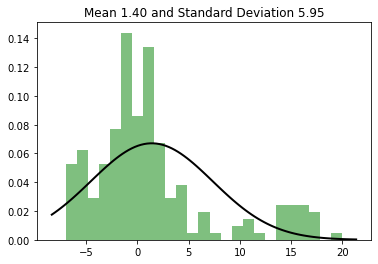

In [18]:
mu, std = norm.fit(match['X']) 
plt.hist(match['X'], bins=25, density=True, color = 'g', alpha=0.5)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth = 2)
title = "Mean {:.2f} and Standard Deviation {:.2f}".format(mu, std)
plt.title(title)
plt.show()

Plot sample 2.

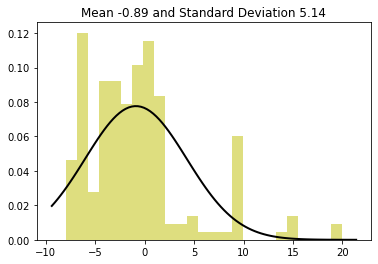

In [19]:
mu, std = norm.fit(match['Y']) 
plt.hist(match['Y'], bins=25, density=True, color = 'y', alpha=0.5)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth = 2)
title = "Mean {:.2f} and Standard Deviation {:.2f}".format(mu, std)
plt.title(title)
plt.show()

Plot both samples against each other.

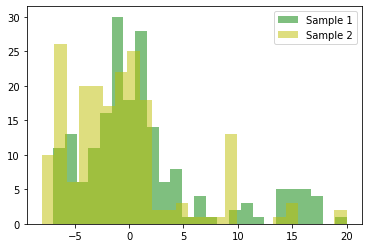

In [20]:
plt.hist(match['X'], bins=25, color = 'g', alpha=0.5, label='Sample 1')
plt.hist(match['Y'], bins=25, color = 'y', alpha=0.5, label='Sample 2')
plt.legend(loc='upper right')
plt.show()

Paired Sample T-test.

In [21]:
stats.ttest_rel(match['X'], match['Y'])

Ttest_relResult(statistic=9.344496631264326, pvalue=2.3911514079544688e-17)

Wilcoxon Signed-Rank Test.

In [22]:
stats.wilcoxon(match['X'], match['Y'])

WilcoxonResult(statistic=2003.0, pvalue=1.0851023580433066e-16)